# STRED Analysis

In [207]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import numpy as np
from collections import Counter
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import time
import datetime

In [208]:
responses_df = pd.read_csv('cleaned_responses.csv') # all responses from HIT 1
validated_df = pd.read_csv('qc_final_results.csv') # post-validation with yes/no label
all_ratings_df = pd.read_csv('rating_hit_results.csv') # validated responses and ratings (from HIT 2)
agg_ratings_df = pd.read_csv('aggregated_ratings.csv') # stressor, response, rating

In [209]:
agg_ratings_df.head()

,Stressor,Response,rating
0,I am being stressed by my roommates being loud...,Complaining will not solve our problem.It will...,7.6
1,I am being stressed by my roommates being loud...,Do not need to stressed and try to understand ...,7.6
2,I am being stressed by my roommates being loud...,I am so sorry you feel that way. Try talking t...,7.8
3,I am being stressed by my roommates being loud...,I can relate to the way you are feeling but yo...,7.8
4,I am being stressed by my roommates being loud...,I definitely can relate to that feeling and it...,7.4


## Summary Stats



*   10 stressors, 140 total responses
*   after validation: 82 yes, 53 no (58.6% validated)
*   average rating is 7.72. all ratings are between 6-9.4.





In [210]:
yes_no = validated_df['Label'].value_counts()

fig = px.bar(validated_df, x=['Yes', 'No'], y=yes_no, text=yes_no, title="Validated Responses Count")
fig.update_layout(
    xaxis_title="Label",
    yaxis_title="Number of Responses",
    width=500,
    height=500
)
fig.show()

In [211]:
agg_ratings_df['rating'].describe()

count    82.000000
mean      7.720732
std       0.696506
min       6.000000
25%       7.250000
50%       7.800000
75%       8.200000
max       9.400000
Name: rating, dtype: float64

In [212]:
fig = px.scatter(agg_ratings_df, y="rating")
fig.update_layout(
    width=500,
    height=500,
        title = 'Response Ratings',
    xaxis = go.XAxis(
        title = 'Responses',
        showticklabels=False),
    yaxis = go.YAxis(
        title = 'Number of Responses'
    ),
    yaxis_range=[0,10]
)
fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:550: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis


/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:578: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis




## Sentiment Analysis

In [213]:
import string
import nltk

nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')

#remove special characters and stop words
def clean_response(resp):
  resp = resp.lower()
  resp = ''.join([c for c in resp if c not in string.punctuation])
  resp = ''.join([(c + ' ') for c in resp.split(' ') if c not in stopword_list])
  return resp

validated_df['cleaned_resp'] = validated_df['Response'].apply(lambda x : clean_response(x))
agg_ratings_df['cleaned_resp'] = agg_ratings_df['Response'].apply(lambda x : clean_response(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [214]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
validated_df['polarity'] = validated_df['cleaned_resp'].apply(lambda x : sid.polarity_scores(x).get('compound'))
agg_ratings_df['polarity'] = agg_ratings_df['cleaned_resp'].apply(lambda x : sid.polarity_scores(x).get('compound'))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [215]:
def getSentimentLabel(x):
  if (x < -0.05):
    return 'Negative'
  if (x > 0.05):
    return 'Positive'
  else:
    return 'Neutral'

validated_df['sentiment'] = validated_df['polarity'].apply(lambda x : getSentimentLabel(x))
agg_ratings_df['sentiment'] = agg_ratings_df['polarity'].apply(lambda x : getSentimentLabel(x))

### Quality Control Sentiment Analysis

Amongst all responses, the average polarity was slightly positive with a score of 0.3675.

In [216]:
validated_df['polarity'].describe()

count    135.000000
mean       0.367547
std        0.531870
min       -0.817600
25%        0.000000
50%        0.548700
75%        0.802000
max        0.982600
Name: polarity, dtype: float64

The bar chart below displays sentiment label separated by responses which were labeled "yes" and "no". Responses validated with "Yes" have a higher proportion of positive-sentiment compared to those labeled with "No".

In [217]:
index = ['Negative', 'Neutral', 'Positive']

yes_df = validated_df[validated_df['Label'] == 'yes']
no_df = validated_df[validated_df['Label'] == 'no']

ylabel_u, ylabel_counts = np.unique(yes_df['sentiment'], return_counts=True)
nlabel_u, nlabel_counts = np.unique(no_df['sentiment'], return_counts=True)

# fig = px.bar(validated_df, x=index, y=label_counts / len(validated_df), text=label_counts / len(validated_df), title="Validated Responses Count")
fig = go.Figure(data = [go.Bar(name="Yes", x=index, y=ylabel_counts/len(yes_df)),
                        go.Bar(name="No", x=index, y=nlabel_counts/len(no_df))],
                layout = go.Layout(title="Proportion of Responses by Sentiment", yaxis_title="Proportion of Total Responses"))
fig.update_layout(
    xaxis_title="Sentiment Label",
    width=500,
    height=500
)
fig.show()

The t-test below compares the mean polarity score of responses labeled "Yes" and responses labeled "No", and resuts in a p-value of 0.007. This means there is significant evidence to support that the average polarity scores are different.

In [218]:
from scipy import stats 

t2, p2 = stats.ttest_ind(yes_df['polarity'], no_df['polarity'])
print("t = " + str(t2))
print("p-value = " + str(p2))

t = 2.736421763360724
p-value = 0.007060173471207246


### Ratings Sentiment Analysis

Amongst the validated responses, the average polarity score was 0.4659, representing a positive sentiment.

In [219]:
agg_ratings_df['polarity'].describe()

count    82.000000
mean      0.465900
std       0.508205
min      -0.791600
25%       0.146575
50%       0.690000
75%       0.877175
max       0.982600
Name: polarity, dtype: float64

In [220]:
fig = px.scatter(agg_ratings_df, x="rating", y="polarity", title="Polarity vs. Rating", trendline="ols")
fig.show()

The Pearson correlation coefficient is 0.11, representing a slight positive correlation between rating and polarity. 

In [221]:
import scipy.stats

(corr_coef, p_value) = scipy.stats.pearsonr(agg_ratings_df['rating'], agg_ratings_df['polarity'])
print("correlation: ", corr_coef)

correlation:  0.11033476403307453


## Content Analysis

In [222]:
tk = TweetTokenizer()

def tokenize_post(post):
  words = tk.tokenize(post)
  words = [word.lower() for word in words]
  return words

In [223]:
agg_ratings_df.head()

,Stressor,Response,rating,cleaned_resp,polarity,sentiment
0,I am being stressed by my roommates being loud...,Complaining will not solve our problem.It will...,7.6,complaining solve problemit make enmity try ma...,0.7351,Positive
1,I am being stressed by my roommates being loud...,Do not need to stressed and try to understand ...,7.6,need stressed try understand coming different ...,0.2960,Positive
2,I am being stressed by my roommates being loud...,I am so sorry you feel that way. Try talking t...,7.8,sorry feel way try talking consult counseling ...,0.4404,Positive
3,I am being stressed by my roommates being loud...,I can relate to the way you are feeling but yo...,7.8,relate way feeling need draw roommatess attent...,0.7430,Positive
4,I am being stressed by my roommates being loud...,I definitely can relate to that feeling and it...,7.4,definitely relate feeling annoying unbearable ...,0.8934,Positive


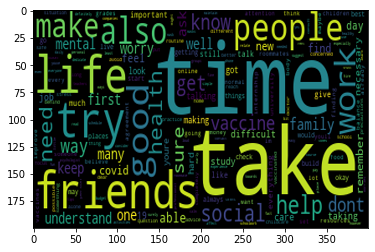

In [224]:
agg_ratings_df['tokens'] = agg_ratings_df['cleaned_resp'].apply(lambda x : tokenize_post(x))
token_lists = agg_ratings_df['tokens'].tolist()
clean_tokens = [tok for tokens in token_lists for tok in tokens]
counter = Counter(clean_tokens)
wordcloud = WordCloud().fit_words(counter)
plt.imshow(wordcloud, interpolation='spline16', aspect='auto')
plt.show()

The list below displays the word and number of times it appeared in a response.

In [225]:
most_common = counter.most_common(30)
most_common

[('time', 34),
 ('take', 30),
 ('friends', 27),
 ('life', 27),
 ('try', 26),
 ('people', 24),
 ('good', 24),
 ('also', 22),
 ('work', 22),
 ('make', 20),
 ('help', 20),
 ('social', 19),
 ('need', 18),
 ('health', 18),
 ('get', 17),
 ('know', 17),
 ('sure', 16),
 ('vaccine', 16),
 ('dont', 16),
 ('way', 15),
 ('family', 15),
 ('understand', 14),
 ('many', 14),
 ('keep', 14),
 ('mental', 14),
 ('one', 14),
 ('first', 13),
 ('worry', 13),
 ('well', 13),
 ('ask', 13)]

## Length Analysis

In [226]:
validated_df['tokens'] = validated_df['cleaned_resp'].apply(lambda x : tokenize_post(x))

validated_df['length'] = validated_df['tokens'].apply(lambda x : len(x))
agg_ratings_df['length'] = agg_ratings_df['tokens'].apply(lambda x : len(x))

### Quality Control Length Analysis

The average number of words in all the responses was 22.48 words.

In [227]:
validated_df['length'].describe()

count    135.000000
mean      22.481481
std       13.072046
min        3.000000
25%       11.500000
50%       22.000000
75%       31.000000
max       61.000000
Name: length, dtype: float64

In [228]:
index = ['yes', 'no']

yes_df = validated_df[validated_df['Label'] == 'yes']
no_df = validated_df[validated_df['Label'] == 'no']
yes_avg = yes_df['length'].mean()
no_avg = no_df['length'].mean()

yes_no = validated_df['Label'].value_counts()

fig = px.bar(validated_df, x=['Yes', 'No'], y=[yes_avg, no_avg], text=[round(yes_avg, 2), round(no_avg, 2)], title="Average Length of Responses")
fig.update_layout(
    xaxis_title="Label",
    yaxis_title="Average Length of Response",
    width=500,
    height=500
)
fig.show()

In [229]:
fig = px.scatter(validated_df, y="length", title="Length based on Label", color="Label")
fig.update_layout(
    xaxis = go.XAxis(
        title = 'Responses',
        showticklabels=False),
)
fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:550: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis




With a very low p-value of 0.00003597, we can conclude responses labeled "Yes" have significantly more words than those labeled "No".

In [230]:
from scipy import stats 

t2, p2 = stats.ttest_ind(yes_df['length'], no_df['length'])
print("t = " + str(t2))
print("p-value = " + str(p2))

t = 4.276631601520445
p-value = 3.5970290907846514e-05


### Ratings Length Analysis

In [231]:
agg_ratings_df['length'].describe()

count    82.000000
mean     26.121951
std      12.389153
min       3.000000
25%      17.250000
50%      26.000000
75%      35.000000
max      61.000000
Name: length, dtype: float64

In [232]:
fig = px.scatter(agg_ratings_df, x="rating", y="length", title="Length vs. Rating", trendline="ols")
fig.show()

In [233]:
import scipy.stats

(corr_coef, p_value) = scipy.stats.pearsonr(agg_ratings_df['rating'], agg_ratings_df['length'])
print("correlation: ", corr_coef)

correlation:  0.116448509102789


## Time Analysis

In [234]:
stressor_hit_df = pd.read_csv('stressor_responses_1.csv')

In [235]:
results = list()

def mergeResults(df):
  for index, row in df.iterrows():
    accept_time = time.mktime(datetime.datetime.strptime(row['AcceptTime'], "%a %b %d %H:%M:%S PDT %Y").timetuple()) / 60
    submit_time = time.mktime(datetime.datetime.strptime(row['SubmitTime'], "%a %b %d %H:%M:%S PDT %Y").timetuple()) / 60
    time_spent = submit_time - accept_time
    results.append([row['Answer.response_1'], time_spent])
    results.append([row['Answer.response_2'], time_spent])

mergeResults(stressor_hit_df)

hit_times_df = pd.DataFrame(results, columns=['Response', 'time_spent'])
hit_times_df

,Response,time_spent
0,Try freelancing or build your own project. ......,3.116667
1,"Social workers are constantly on the go, deali...",3.116667
2,I'm sure you would be able to find one with so...,2.933333
3,It's difficult to balance social and work life...,2.933333
4,I know it's a complicated context to find a jo...,9.350000
...,...,...
137,I would go to the doctor and express your conc...,13.500000
138,I am so sorry you feel that way. Try talking t...,2.550000
139,I completely understand that. There are telehe...,2.550000
140,I can relate to the way you are feeling but yo...,9.066667


In [236]:
hit_times_df = hit_times_df.dropna()
hit_times_df['cleaned_resp'] = hit_times_df['Response'].apply(lambda x : clean_response(x))
hit_times_df['tokens'] = hit_times_df['cleaned_resp'].apply(lambda x : tokenize_post(x))
hit_times_df['combine_tokens'] = hit_times_df['tokens'].apply(lambda x : '_'.join(x))
validated_df['combine_tokens'] = validated_df['tokens'].apply(lambda x : '_'.join(x))
agg_ratings_df['combine_tokens'] = agg_ratings_df['tokens'].apply(lambda x : '_'.join(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

### Quality Control Time Analysis

Average of all responses took ~7.4 minutes.

In [237]:
time_validated_df = validated_df.merge(hit_times_df, on="combine_tokens", how="left")
time_validated_df = time_validated_df.dropna()
time_validated_df.describe()

,polarity,length,time_spent
count,137.000000,137.000000,137.000000
mean,0.366255,21.372263,7.396107
std,0.516861,12.888097,6.888768
min,-0.791600,3.000000,0.100000
25%,0.025800,10.000000,2.166667
50%,0.466400,21.000000,5.466667
75%,0.778300,30.000000,9.483333
max,0.982600,61.000000,27.016667


In [238]:
fig = px.scatter(time_validated_df, y="time_spent", title="Time Spent based on Label", color="Label")
fig.update_layout(
    xaxis = go.XAxis(
        title = 'Responses',
        showticklabels=False),
)
fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:550: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis




oh...no difference between time spent :(

In [239]:
from scipy import stats 

yes_df = time_validated_df[time_validated_df['Label'] == 'yes']
no_df = time_validated_df[time_validated_df['Label'] == 'no']

t2, p2 = stats.ttest_ind(yes_df['time_spent'], no_df['time_spent'])
print("t = " + str(t2))
print("p-value = " + str(p2))

t = 0.014209566201517664
p-value = 0.9886837660710825


#### Ratings Time Analysis

In [240]:
ratings_validated_df = agg_ratings_df.merge(hit_times_df, on="combine_tokens", how="left")
ratings_validated_df = ratings_validated_df.dropna()
ratings_validated_df.describe()

,rating,polarity,length,time_spent
count,81.000000,81.000000,81.000000,81.000000
mean,7.707407,0.449352,26.296296,7.403086
std,0.703878,0.515964,12.352575,6.409734
min,6.000000,-0.791600,3.000000,0.583333
25%,7.400000,0.128000,17.000000,2.683333
50%,7.800000,0.670500,26.000000,5.466667
75%,8.200000,0.877900,35.000000,9.066667
max,9.400000,0.982600,61.000000,25.483333


In [241]:
fig = px.scatter(ratings_validated_df, y="time_spent", x="rating", title="Time Spent vs. Rating", trendline="ols")
fig.show()

In [242]:
import scipy.stats

(corr_coef, p_value) = scipy.stats.pearsonr(ratings_validated_df['rating'], ratings_validated_df['time_spent'])
print("correlation: ", corr_coef)
print("p_value: ", p_value)

correlation:  0.11092474450282866
p_value:  0.32420552462038316
